In [1]:
import numpy as np
import pandas as pd
import os
import torch
from collections import Counter
import networkx as nx

import torch_geometric
from torch_geometric.data import Dataset, Data
from torch_geometric.utils.convert import to_networkx

import itertools
import math
from collections import defaultdict
from time import time

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from tqdm import tqdm

from preprocess_utils import preprocess_text
from embedding_utils import *
from utils import print_graph_detail

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kando\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('data/glove.6B.50d.txt')
def trim_text_from_embedding(text):
    words = text.split()
    actual_word = list()
    for word in words:
        if word in word_to_index.keys():
            actual_word.append(word)
    text = ' '.join([word for word in actual_word])
    return text


In [3]:
def get_window(content_lst, window_size):
    word_window_freq = defaultdict(int)  # w(i)
    word_pair_count = defaultdict(int)  # w(i, j)
    windows_len = 0
    for words in tqdm(content_lst, desc="Split by window"):
        windows = list()

        if isinstance(words, str):
            words = words.split()
        length = len(words)

        if length <= window_size:
            windows.append(words)
        else:
            for j in range(length - window_size + 1):
                window = words[j: j + window_size]
                windows.append(list(set(window)))

        for window in windows:
            for word in window:
                word_window_freq[word] += 1

            for word_pair in itertools.combinations(window, 2):
                word_pair_count[word_pair] += 1

        windows_len += len(windows)
    return word_window_freq, word_pair_count, windows_len

In [4]:
def cal_pmi(W_ij, W, word_freq_1, word_freq_2):
    p_i = word_freq_1 / W
    p_j = word_freq_2 / W
    p_i_j = W_ij / W
    pmi = math.log(p_i_j / (p_i * p_j))

    return pmi

In [5]:
def count_pmi(windows_len, word_pair_count, word_window_freq, threshold):
    word_pmi_lst = list()
    word_pmi_dict = dict()
    for word_pair, W_i_j in tqdm(word_pair_count.items(), desc="Calculate pmi between words"):
        word_freq_1 = word_window_freq[word_pair[0]]
        word_freq_2 = word_window_freq[word_pair[1]]

        pmi = cal_pmi(W_i_j, windows_len, word_freq_1, word_freq_2)
        if pmi <= threshold:
            continue

        word_pmi_lst.append([word_pair[0], word_pair[1], pmi])
        word_pmi_dict[(word_pair[0], word_pair[1])] = pmi
        word_pmi_dict[(word_pair[1], word_pair[0])] = pmi
        
    return word_pmi_dict,word_pmi_lst

In [6]:
def get_pmi_edge(content_lst,window_size=20, threshold=0.5):

    pmi_start = time()
    word_window_freq, word_pair_count, windows_len = get_window(content_lst,
                                                                window_size=window_size)

    pmi_edge_dict,pmi_edge_lst = count_pmi(windows_len, word_pair_count, word_window_freq, threshold)
    print("Total number of edges between word:", len(pmi_edge_lst))
    pmi_time = time() - pmi_start
    return pmi_edge_dict,pmi_edge_lst,pmi_time

In [7]:
class BuildGraph:
    def __init__(self, dataset_pos,len_dataset_pos,dataset_neg,len_dataset_neg):
        data_path = "aclImdb/train"
        self.graph_path = "data/graph"
        if not os.path.exists(self.graph_path):
            os.makedirs(self.graph_path)

        self.word2id = dict() 
        self.id2word = dict() 

        self.dataset_pos = dataset_pos
        self.len_dataset_pos = len_dataset_pos
        self.dataset_neg = dataset_neg
        self.len_dataset_neg = len_dataset_neg

        self.g = nx.Graph()

        self.text_path_pos = f"{data_path}/{dataset_pos}"
        self.text_path_neg = f"{data_path}/{dataset_neg}"

        self.load_text_data()
        self.get_tfidf_edge()
        self.get_pmi_edge()
        self.store_torch_data()
        self.save()

    def load_text_data(self):
        content_lst = list()
        pos_content_lst = list()
        neg_content_lst = list()

        i = 0
        for filename in tqdm(os.listdir(self.text_path_pos),desc="loading pos text"):
            f = os.path.join(self.text_path_pos, filename)
            content = list(open(f,encoding="utf8"))
            content = trim_text_from_embedding(preprocess_text(content[0]))
            content_lst.append(content)
            pos_content_lst.append(content)

            i = i+1
            if i == self.len_dataset_pos:
                break

        i = 0
        for filename in tqdm(os.listdir(self.text_path_neg),desc="loading neg text"):
            
            f = os.path.join(self.text_path_neg, filename)
            content = list(open(f,encoding="utf8"))
            content = trim_text_from_embedding(preprocess_text(content[0]))
            content_lst.append(content)
            neg_content_lst.append(content)
                
            i = i+1
            if i == self.len_dataset_neg:
                break

        self.content = content_lst
        self.content_pos = pos_content_lst
        self.content_neg = neg_content_lst
        print("pmi read file len:", len(content_lst))

    def store_torch_data(self):

        for ind , content in tqdm(enumerate(self.content_pos),desc="storing positive graph data"):
            res = []
            [res.append(x) for x in content if x not in res]
            content = ' '.join(word for word in res)
            
            node_feats = self.get_node_features(content)
            edge_index = self.get_adjacency_info(content)
            edge_feats = self.get_edge_features(content,ind)
            label = [1,1]

            data = Data(x=node_feats, 
                        edge_index=edge_index,
                        edge_attr=edge_feats,
                        y=label,
                        about="positive"
                        ) 
                        
            torch.save(data, 
                os.path.join(f"{self.graph_path}/dataset/", 
                                f'data_{ind}.pt'))

        for ind , content in tqdm(enumerate(self.content_neg),desc="storing positive graph data"):
            res = []
            [res.append(x) for x in content if x not in res]
            content = ' '.join(word for word in res)

            node_feats = self.get_node_features(content)
            edge_index = self.get_adjacency_info(content)
            edge_feats = self.get_edge_features(content,ind+self.len_dataset_pos)
            label = [1,-1]

            data = Data(x=node_feats, 
                        edge_index=edge_index,
                        edge_attr=edge_feats,
                        y=label,
                        about="negative"
                        ) 

            torch.save(data, 
                os.path.join(f"{self.graph_path}/dataset/", 
                                f'data_{ind+self.len_dataset_pos}.pt'))
    
    def get_node_features(self,content):
        """ 
        This will return a matrix / 2d array of the shape
        [Number of Nodes, Node Feature size]
        """
        all_node_feats = []
        
        for word in content.split():
            all_node_feats.append(word_to_vec_map[word])

        all_node_feats = np.asarray(all_node_feats)
        all_node_feats = torch.tensor(all_node_feats, dtype=torch.float)
        return torch.concat([torch.mean(all_node_feats,0)[None,:],all_node_feats],0)

    def get_adjacency_info(self,content):
        """ 
        This will return a matrix / 2d array of the shape
        [2, Number of edges]
        """
        edge_indices = []
        total_nodes = len(content.split())+1
        for i in range(total_nodes):
            for j in range(i+1,total_nodes):
                edge_indices.append([i,j])
                edge_indices.append([j,i])
        edge_indices = torch.tensor(edge_indices).t().contiguous()
        return edge_indices

    def get_edge_features(self,content,ind):
        """ 
        This will return a matrix / 2d array of the shape
        [Number of edges, edge features]
        """    
        all_edge_feats = []
        content = content.split()
        total_nodes = len(content)+1
        value = self.tfidf_vec[ind].data

        for i in range(0,total_nodes-1):
            # self.word2id(content[i])
            all_edge_feats.append(0)
            all_edge_feats.append(0)         

        for i in range(0,total_nodes-1):
            for j in range(i+1,total_nodes-1):
                if (content[i],content[j]) in self.pmi_edge_dict:
                    all_edge_feats.append(self.pmi_edge_dict[(content[i],content[j])])
                    all_edge_feats.append(self.pmi_edge_dict[(content[j],content[i])])
                else:
                    all_edge_feats.append(0)
                    all_edge_feats.append(0)
                
        all_edge_feats = np.asarray(all_edge_feats)
        return torch.tensor(all_edge_feats, dtype=torch.float)

    def get_pmi_edge(self):
        pmi_edge_dict,pmi_edge_lst, self.pmi_time = get_pmi_edge(self.content,window_size=20, threshold=0.0)
        self.pmi_edge_lst = pmi_edge_lst
        self.pmi_edge_dict = pmi_edge_dict
        print("pmi time:", self.pmi_time)

        for edge_item in self.pmi_edge_lst:
            word_indx1 = self.node_num + self.word2id[edge_item[0]]
            word_indx2 = self.node_num + self.word2id[edge_item[1]]
            if word_indx1 == word_indx2:
                continue
            self.g.add_edge(word_indx1, word_indx2, weight=edge_item[2])

        print_graph_detail(self.g)

    def get_tfidf_edge(self):
        tfidf_vec,text_tfidf = self.get_tfidf_vec()
        self.tfidf_vec = tfidf_vec   
        self.text_tfidf = text_tfidf

        count_lst = list()
        for ind, row in tqdm(enumerate(self.tfidf_vec),
                             desc="generate tfidf edge"):
            count = 0
            for col_ind, value in zip(row.indices, row.data):
                word_ind = self.node_num + col_ind
                self.g.add_edge(ind, word_ind, weight=value)
                count += 1
            count_lst.append(count)

        print_graph_detail(self.g)

    def get_tfidf_vec(self):
        start = time()
        text_tfidf = Pipeline([
            ("vect", CountVectorizer(min_df=1,
                                     max_df=1.0,
                                     token_pattern=r"\S+",
                                     )),
            ("tfidf", TfidfTransformer(norm=None,
                                       use_idf=True,
                                       smooth_idf=False,
                                       sublinear_tf=False
                                       ))
        ])

        tfidf_vec = text_tfidf.fit_transform(self.content)

        self.tfidf_time = time() - start
        print("tfidf time:", self.tfidf_time)
        print("tfidf_vec shape:", tfidf_vec.shape)
        print("tfidf_vec type:", type(tfidf_vec))

        self.node_num = tfidf_vec.shape[0]

        vocab_lst = text_tfidf["vect"].get_feature_names()
        print("vocab_lst len:", len(vocab_lst))
        for ind, word in enumerate(vocab_lst):
            self.word2id[word] = ind
            self.id2word[ind] = word

        self.vocab_lst = vocab_lst

        return tfidf_vec,text_tfidf

    def save(self):
        print("total time:", self.pmi_time + self.tfidf_time)
        nx.write_weighted_edgelist(self.g,
                                   f"{self.graph_path}/total.txt")

        print("\n")

In [9]:
graph = BuildGraph("pos",2000,"neg",2000)

loading neg text:  16%|█▌        | 1999/12500 [00:14<01:18, 133.69it/s]


pmi read file len: 4000


generate tfidf edge: 416it [00:00, 4140.16it/s]

tfidf time: 0.4652588367462158
tfidf_vec shape: (4000, 30411)
tfidf_vec type: <class 'scipy.sparse.csr.csr_matrix'>
vocab_lst len: 30411


generate tfidf edge: 4000it [00:01, 2313.75it/s]
Split by window:   1%|          | 23/4000 [00:00<00:17, 225.92it/s]

+---------+----------+-------------+------------+----------+
|  Nodes  |  Edges   |  Selfloops  |  Isolates  |  Index   |
+---------+----------+-------------+------------+----------+
|  34411  |  378472  |      0      |     0      |  1.0000  |
+---------+----------+-------------+------------+----------+


Calculate pmi between words: 100%|██████████| 4610514/4610514 [00:18<00:00, 249810.88it/s]


Total number of edges between word: 3649079
pmi time: 50.129395723342896
+---------+-----------+-------------+------------+----------+
|  Nodes  |   Edges   |  Selfloops  |  Isolates  |  Index   |
+---------+-----------+-------------+------------+----------+
|  34411  |  3761101  |      0      |     0      |  1.0000  |
+---------+-----------+-------------+------------+----------+


storing positive graph data: 2000it [00:46, 43.06it/s] 
storing positive graph data: 2000it [00:18, 106.61it/s]


total time: 50.59465456008911




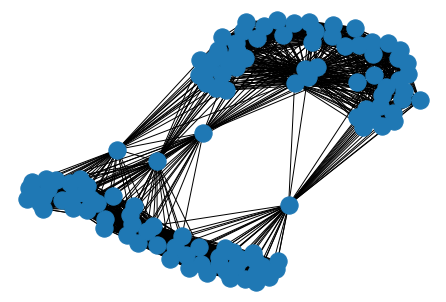

In [243]:
nx.draw(graph.g, with_labels=False)

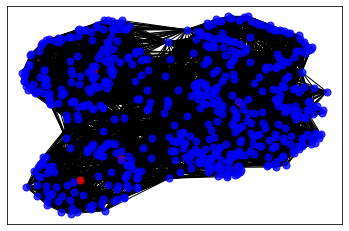

In [163]:
pos=nx.spring_layout(graph.g)
nx.draw_networkx_nodes(graph.g,pos,
                       nodelist=range(0,graph.node_num),
                       node_color='r',
                       node_size=50, alpha=0.8)
nx.draw_networkx_nodes(graph.g,pos,
                       nodelist=range(graph.node_num, nx.number_of_nodes(graph.g)),
                       node_color='b',
                       node_size=50, alpha=0.8)
nx.draw_networkx_edges(graph.g,pos)  

In [165]:
len(graph.vocab_lst)

557

In [251]:
data = torch.load("data/graph/dataset/data_0.pt")

In [255]:
data

Data(x=[73, 50], edge_index=[2, 5256], edge_attr=[5256], y=[2], about='positive')

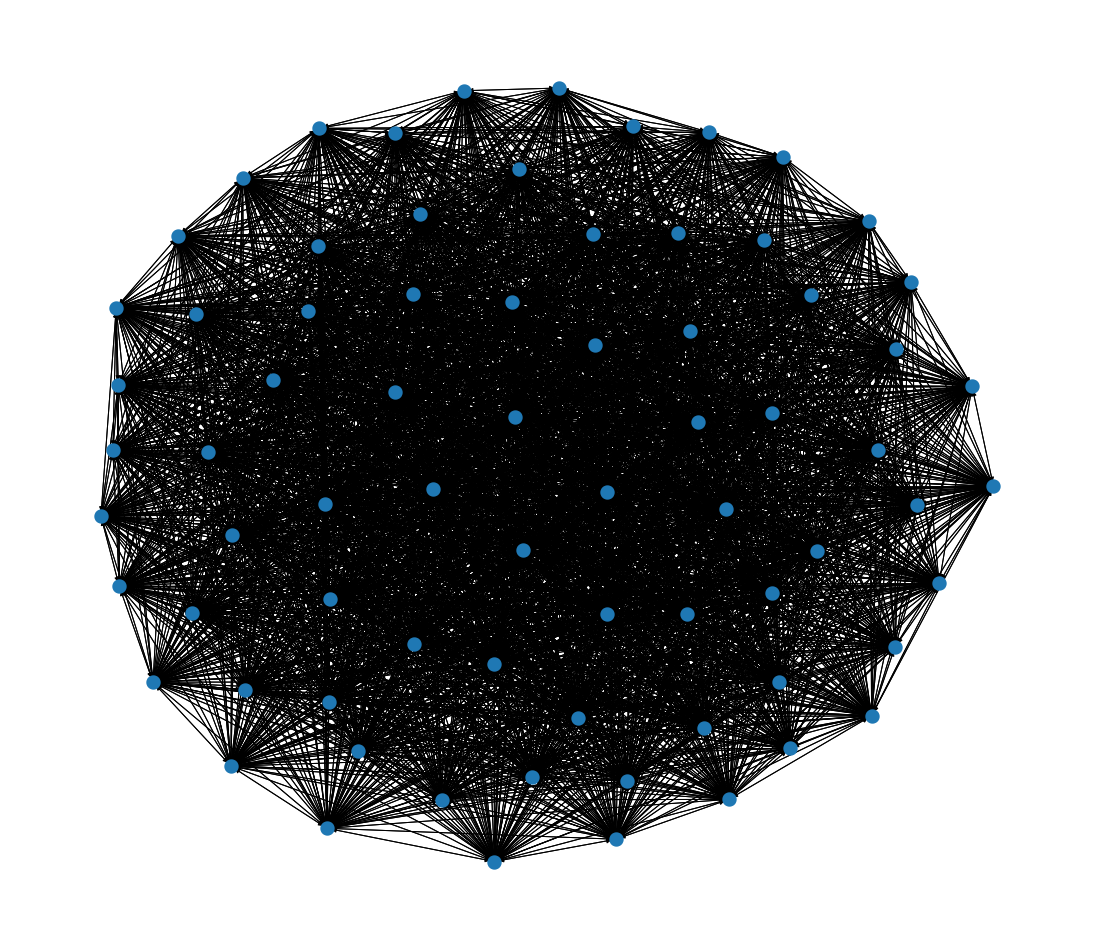

In [262]:
vis = to_networkx(data)

import matplotlib.pyplot as plt
plt.figure(1,figsize=(15,13)) 
nx.draw(vis, cmap=plt.get_cmap('Set3'),node_size=70,linewidths=6)
plt.show()